In [ ]:
# mount data
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/Thesis/data'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

#from sklearn.metrics import mean_squared_error

#from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# settings
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (8, 6)

<ipython-input-4-33013544e223>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


## Load T2 data

In [ ]:

def load_T2_data(country_name):
  T2_balances = pd.read_excel(data_folder+'/TGB_month_avg.xls',header=1)
  country = [x for x in T2_balances['REF_AREA.265 [desc.]'].unique() if country_name in x][0]
  col_to_use = ['Obs. date','Obs. value']
  country_T2 = T2_balances[T2_balances['REF_AREA.265 [desc.]']== country]
  country_T2 = country_T2[col_to_use].reset_index(drop=True)
  country_T2.rename(columns={'Obs. value':'T2_balance','Obs. date':'date'},inplace=True)
  country_T2 = country_T2.sort_values('date',ascending=True).reset_index(drop=True)
  country_T2['date'] = pd.to_datetime(country_T2.date).dt.to_period('M')
  return country_T2

In [ ]:
# load Italy T2 data
Italy_T2 = load_T2_data('Italy')

In [ ]:
# calculate monthly change
Italy_T2['1st_diff'] = Italy_T2['T2_balance'].diff(1)

In [ ]:
Italy_T2.shape

(267, 3)

In [ ]:
# get lags whose partial autocorrelation coef is larger than 0.15
from statsmodels.tsa.stattools import pacf
pacf_b = pacf(Italy_T2['1st_diff'].dropna().values, nlags=50,)
selected_lags = np.where(abs(pacf_b)>0.15)

In [ ]:
# add those lags in dataframe
for lag in selected_lags[0][1:]:
  Italy_T2['1st_diff_{}lag'.format(lag)] = Italy_T2['1st_diff'].shift(lag)

In [ ]:
Italy_T2.head()

,date,T2_balance,1st_diff,1st_diff_1lag,1st_diff_3lag,1st_diff_6lag,1st_diff_33lag
0,2001-01,-7614.55,NaN,NaN,NaN,NaN,NaN
1,2001-02,-2692.00,4922.55,NaN,NaN,NaN,NaN
2,2001-03,5488.41,8180.41,4922.55,NaN,NaN,NaN
3,2001-04,4106.70,-1381.71,8180.41,NaN,NaN,NaN
4,2001-05,-7360.04,-11466.74,-1381.71,4922.55,NaN,NaN


#### ARIMA

In [ ]:
# split train test data for ARIMA
y_train,y_test = np.split(Italy_T2['1st_diff'].dropna(), [int(len(Italy_T2['1st_diff'].dropna())*0.7)])

In [ ]:
# a function to calculate SMAPE
def smape(A, F):
      return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

Model Runtime: 64.394938
Test RMSE: 15779.532
Test MAPE: 4.585
TEST SMAPE: 130.08% 
TEST R_squared: -0.00 


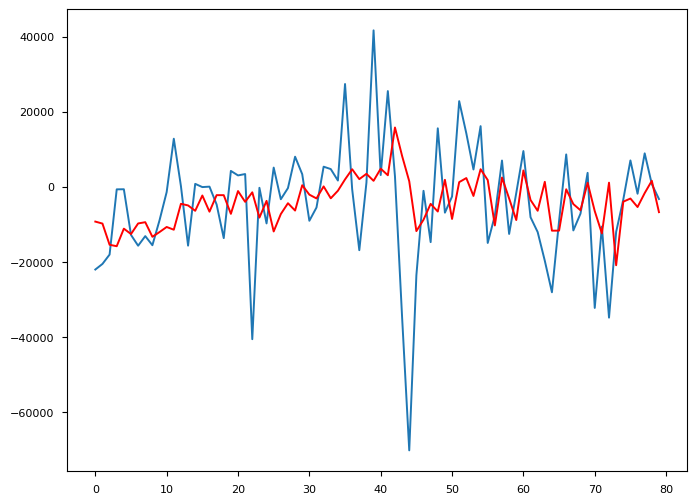

In [ ]:
# ARIMA model with walk forward validation
from statsmodels.tsa.arima.model import ARIMA

history = [x for x in y_train]
observations = y_test.tolist()
predictions = list()

start = datetime.datetime.now()

# walk-forward validation
for t in range(len(observations)):
 model = ARIMA(history, order=(3,1,3))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = observations[t]
 history.append(obs)
 #print('predicted=%f, expected=%f' % (yhat, obs))

end = datetime.datetime.now()

# evaluate forecasts
run_time = end-start
print('Model Runtime: {}'.format(run_time.total_seconds()))
rmse = np.sqrt(mean_squared_error(observations, predictions))
print('Test RMSE: %.3f' % rmse)
MAPE = mean_absolute_percentage_error(observations, predictions)
print('Test MAPE: %.3f' % MAPE)
smape_ = smape(np.array(observations), np.array(predictions))
print('TEST SMAPE: {:0.2f}% '.format(smape_))
r2 = r2_score(observations, predictions)
print('TEST R_squared: {:0.2f} '.format(r2))

# plot forecasts against actual outcomes
plt.plot(observations)
plt.plot(predictions, color='red')
plt.show()

## Load CA, KA, FA data

In [ ]:
def load_BOP_data(account_type,country_name):
  BOP = pd.read_excel(data_folder+'/{}_monthly.xls'.format(account_type),header=1)
  country = [x for x in BOP['REF_AREA.343 [desc.]'].unique() if country_name in x][0]
  country_BOP = BOP[BOP['REF_AREA.343 [desc.]']== country].reset_index(drop=True)
  useful_col2 = ['Obs. date','Obs. value']
  country_BOP = country_BOP[useful_col2]
  country_BOP = country_BOP[country_BOP['Obs. date']>'2001']
  country_BOP = country_BOP.sort_values(by='Obs. date',ascending=True).reset_index(drop=True)
  country_BOP = country_BOP.rename(columns={'Obs. date':'date'})
  if account_type == 'CA':
    country_BOP.rename(columns={'Obs. value':'Current_Account'},inplace=True)
  elif account_type == 'KA':
    country_BOP.rename(columns={'Obs. value':'Capital_Account'},inplace=True)
  elif account_type == 'FA':
    country_BOP.rename(columns={'Obs. value':'Financial_Account'},inplace=True)
  country_BOP['date'] = pd.to_datetime(country_BOP.date).dt.to_period('M')
  return country_BOP

In [ ]:
# load BOP data
CA_DE  = load_BOP_data('CA','Italy')
#KA_DE = load_BOP_data('KA','Germany')
FA_DE = load_BOP_data('FA','Italy')

In [ ]:
# merge into one dataframe
BOP_DE = CA_DE.merge(FA_DE,on='date')

In [ ]:
BOP_DE.shape

(182, 3)

In [ ]:
BOP_DE.tail()

,date,Current_Account,Financial_Account
177,2022-10,-103.0,4843.0
178,2022-11,-126.0,5131.0
179,2022-12,3259.0,7719.0
180,2023-01,-5225.0,-10747.0
181,2023-02,-884.0,-7198.0


In [ ]:
# calculate monthly changes of T2
BOP_DE['Current_Account_1st_diff'] = BOP_DE['Current_Account'].diff(1)
#BOP_DE['Capital_Account_1st_diff'] = BOP_DE['Capital_Account'].diff(1)
BOP_DE['Financial_Account_1st_diff'] = BOP_DE['Financial_Account'].diff(1)

In [ ]:
# rearrange the columns
BOP_DE = BOP_DE[['date','Current_Account_1st_diff',
       #'Capital_Account_1st_diff',
       'Financial_Account_1st_diff']]

In [ ]:
BOP_DE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 181
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype    
---  ------                      --------------  -----    
 0   date                        182 non-null    period[M]
 1   Current_Account_1st_diff    181 non-null    float64  
 2   Financial_Account_1st_diff  181 non-null    float64  
dtypes: float64(2), period[M](1)
memory usage: 5.7 KB


## Load other features


In [ ]:
def load_GDP_data(country_name):
  GDP = pd.read_excel(data_folder+'/GDP_unadjusted.xls',header=1)
  country = [x for x in GDP['REF_AREA.249 [desc.]'].unique() if country_name in x][0]
  country_GDP = GDP[GDP['REF_AREA.249 [desc.]'] == country].reset_index(drop=True)
  col_to_use = ['Obs. formatted date','Obs. value']
  country_GDP = country_GDP[col_to_use]
  country_GDP.rename(columns={'Obs. value':'GDP'},inplace=True)
  country_GDP = country_GDP.sort_values(by='Obs. formatted date',ascending=True).reset_index(drop=True)
  country_GDP = country_GDP[country_GDP['Obs. formatted date']>'2001'].reset_index(drop=True)
  country_GDP = country_GDP.rename(columns={'Obs. formatted date':'date'})
  country_GDP['date'] = pd.to_datetime(country_GDP['date']).dt.to_period('M')
  return country_GDP

In [ ]:
# load GDP data
GDP_data = load_GDP_data('Italy').reset_index(drop=True)

In [ ]:
# calculate the quarterly difference
GDP_data['GDP'] = GDP_data['GDP'].diff(1)

bond data : https://fred.stlouisfed.org/series/IRLTLT01DEM156N

In [ ]:
# load government bond data
bond_data = pd.read_csv(data_folder+'/Italy_bond.csv')
bond_data = bond_data[bond_data['DATE']>'2001'].reset_index(drop=True)
bond_data.rename(columns={'DATE':'date','IRLTLT01ESM156N':'Gov_bond_yield'},inplace=True)
bond_data['date'] = pd.to_datetime(bond_data['date']).dt.to_period('M')

In [ ]:
bond_data.head()

,date,Gov_bond_yield
0,2001-01,5.076909
1,2001-02,5.116750
2,2001-03,5.040909
3,2001-04,5.179526
4,2001-05,5.363182


In [ ]:
def load_Stress_data(country_name):
  GDP = pd.read_excel(data_folder+'/Country-Level Index of Financial Stress.xls',header=1)
  country = [x for x in GDP['REF_AREA.276 [desc.]'].unique() if country_name in x][0]
  country_GDP = GDP[GDP['REF_AREA.276 [desc.]'] == country].reset_index(drop=True)
  col_to_use = ['Obs. formatted date','Obs. value']
  country_GDP = country_GDP[col_to_use]
  country_GDP.rename(columns={'Obs. value':'Stress_indicator'},inplace=True)
  country_GDP = country_GDP.sort_values(by='Obs. formatted date',ascending=True).reset_index(drop=True)
  country_GDP = country_GDP[country_GDP['Obs. formatted date']>'2001'].reset_index(drop=True)
  country_GDP = country_GDP.rename(columns={'Obs. formatted date':'date'})
  country_GDP['date'] = pd.to_datetime(country_GDP['date']).dt.to_period('M')
  return country_GDP

In [ ]:
# load financial stress indicator data
stress_data = load_Stress_data('Italy')

In [ ]:
def load_inflation_data(country_name):
  GDP = pd.read_excel(data_folder+'/inflation rate.xls',header=1)
  country = [x for x in GDP['REF_AREA.19 [desc.]'].unique() if country_name in x][0]
  country_GDP = GDP[GDP['REF_AREA.19 [desc.]'] == country].reset_index(drop=True)
  col_to_use = ['Obs. formatted date','Obs. value']
  country_GDP = country_GDP[col_to_use]
  country_GDP.rename(columns={'Obs. value':'inflation_rate'},inplace=True)
  country_GDP = country_GDP.sort_values(by='Obs. formatted date',ascending=True).reset_index(drop=True)
  country_GDP = country_GDP[country_GDP['Obs. formatted date']>'2001'].reset_index(drop=True)
  country_GDP = country_GDP.rename(columns={'Obs. formatted date':'date'})
  country_GDP['date'] = pd.to_datetime(country_GDP['date']).dt.to_period('M')
  return country_GDP

In [ ]:
# load inflation data
inflation_data = load_inflation_data('Italy')

In [ ]:
inflation_data.head()

,date,inflation_rate
0,2001-01,2.5
1,2001-02,1.5
2,2001-03,2.2
3,2001-04,3.0
4,2001-05,2.8


## Feature preparation

### Moving Average

In [ ]:
# combine all features into one dataframe
data_lst = [Italy_T2,bond_data,stress_data,inflation_data,GDP_data]
feature_df = BOP_DE.copy()
for data in data_lst:
  #print(data)
  feature_df = feature_df.merge(data,how='left',on='date')

feature_df.drop(columns='T2_balance',inplace=True)

In [ ]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 181
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype    
---  ------                      --------------  -----    
 0   date                        182 non-null    period[M]
 1   Current_Account_1st_diff    181 non-null    float64  
 2   Financial_Account_1st_diff  181 non-null    float64  
 3   1st_diff                    182 non-null    float64  
 4   1st_diff_1lag               182 non-null    float64  
 5   1st_diff_3lag               182 non-null    float64  
 6   1st_diff_6lag               182 non-null    float64  
 7   1st_diff_33lag              182 non-null    float64  
 8   Gov_bond_yield              182 non-null    float64  
 9   Stress_indicator            182 non-null    float64  
 10  inflation_rate              182 non-null    float64  
 11  GDP                         60 non-null     float64  
dtypes: float64(11), period[M](1)
memory usage: 18.5 KB


In [ ]:
feature_df.head()

,date,Current_Account_1st_diff,Financial_Account_1st_diff,1st_diff,1st_diff_1lag,1st_diff_3lag,1st_diff_6lag,1st_diff_33lag,Gov_bond_yield,Stress_indicator,inflation_rate,GDP
0,2008-01,NaN,NaN,-2681.95,11119.60,-10857.17,13201.12,1346.89,4.182727,0.1680,3.2,-42783.5
1,2008-02,2926.0,8026.0,-9022.48,-2681.95,-4088.05,-2193.06,-10287.62,4.144095,0.1315,3.0,NaN
2,2008-03,-1142.0,-4375.0,17671.24,-9022.48,11119.60,17258.65,8641.82,4.117632,0.2560,3.6,NaN
3,2008-04,2784.0,12358.0,4849.86,17671.24,-2681.95,-10857.17,5084.90,4.310273,0.1582,3.4,23607.6
4,2008-05,1140.0,-25895.0,-6545.90,4849.86,-9022.48,-4088.05,-945.03,4.422150,0.1051,3.8,NaN


In [ ]:
feature_df.shape

(182, 12)

In [ ]:
# forward fill GDP data
feature_df[['GDP']] = feature_df[['GDP']].ffill()

In [ ]:
feature_df.isna().sum()

date                          0
Current_Account_1st_diff      1
Financial_Account_1st_diff    1
1st_diff                      0
1st_diff_1lag                 0
1st_diff_3lag                 0
1st_diff_6lag                 0
1st_diff_33lag                0
Gov_bond_yield                0
Stress_indicator              0
inflation_rate                0
GDP                           0
dtype: int64

In [ ]:
# calculate moving averages
feature_df['Moving_Avg_3m'] = feature_df['1st_diff'].rolling(3,min_periods=1).mean().shift(1)
#feature_df['Moving_Avg_6m'] = feature_df['1st_diff'].rolling(6,min_periods=1).mean().shift(1)
feature_df['Moving_Avg_9m'] = feature_df['1st_diff'].rolling(9,min_periods=1).mean().shift(1)
#feature_df['Moving_Avg_12m'] = feature_df['1st_diff'].rolling(12,min_periods=1).mean().shift(1)

In [ ]:
feature_df.head()

,date,Current_Account_1st_diff,Financial_Account_1st_diff,1st_diff,1st_diff_1lag,1st_diff_3lag,1st_diff_6lag,1st_diff_33lag,Gov_bond_yield,Stress_indicator,inflation_rate,GDP,Moving_Avg_3m,Moving_Avg_9m
0,2008-01,NaN,NaN,-2681.95,11119.60,-10857.17,13201.12,1346.89,4.182727,0.1680,3.2,-42783.5,NaN,NaN
1,2008-02,2926.0,8026.0,-9022.48,-2681.95,-4088.05,-2193.06,-10287.62,4.144095,0.1315,3.0,-42783.5,-2681.950000,-2681.950000
2,2008-03,-1142.0,-4375.0,17671.24,-9022.48,11119.60,17258.65,8641.82,4.117632,0.2560,3.6,-42783.5,-5852.215000,-5852.215000
3,2008-04,2784.0,12358.0,4849.86,17671.24,-2681.95,-10857.17,5084.90,4.310273,0.1582,3.4,23607.6,1988.936667,1988.936667
4,2008-05,1140.0,-25895.0,-6545.90,4849.86,-9022.48,-4088.05,-945.03,4.422150,0.1051,3.8,23607.6,4499.540000,2704.167500


In [ ]:
# calculate volatility
#feature_df['Volatility_6m'] = feature_df['1st_diff'].rolling(6,min_periods=6).std().shift(1)*np.sqrt(6)
#feature_df['Volatility_6m'] = feature_df['1st_diff'].rolling(6,min_periods=1).std().shift(1)*np.sqrt(6)
feature_df['Volatility_24m'] = feature_df['1st_diff'].rolling(24,min_periods=24).std().shift(1)*np.sqrt(24)
#feature_df['Volatility_12m'] = feature_df['1st_diff'].rolling(12,min_periods=1).std().shift(1)*np.sqrt(12)

### Encode ordnial

In [ ]:
def encode_cyclicals(df_x):
    #"month"

    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)

    return df_x

In [ ]:
# encode month
feature_df['year'] = feature_df['date'].dt.year
feature_df['month'] = feature_df['date'].dt.month
feature_df = feature_df.drop(columns='date')
feature_df = encode_cyclicals(feature_df)

In [ ]:
# fill na with 0
feature_df.fillna(0,inplace=True)

In [ ]:
feature_df.reset_index(drop=True,inplace=True)

<Axes: >

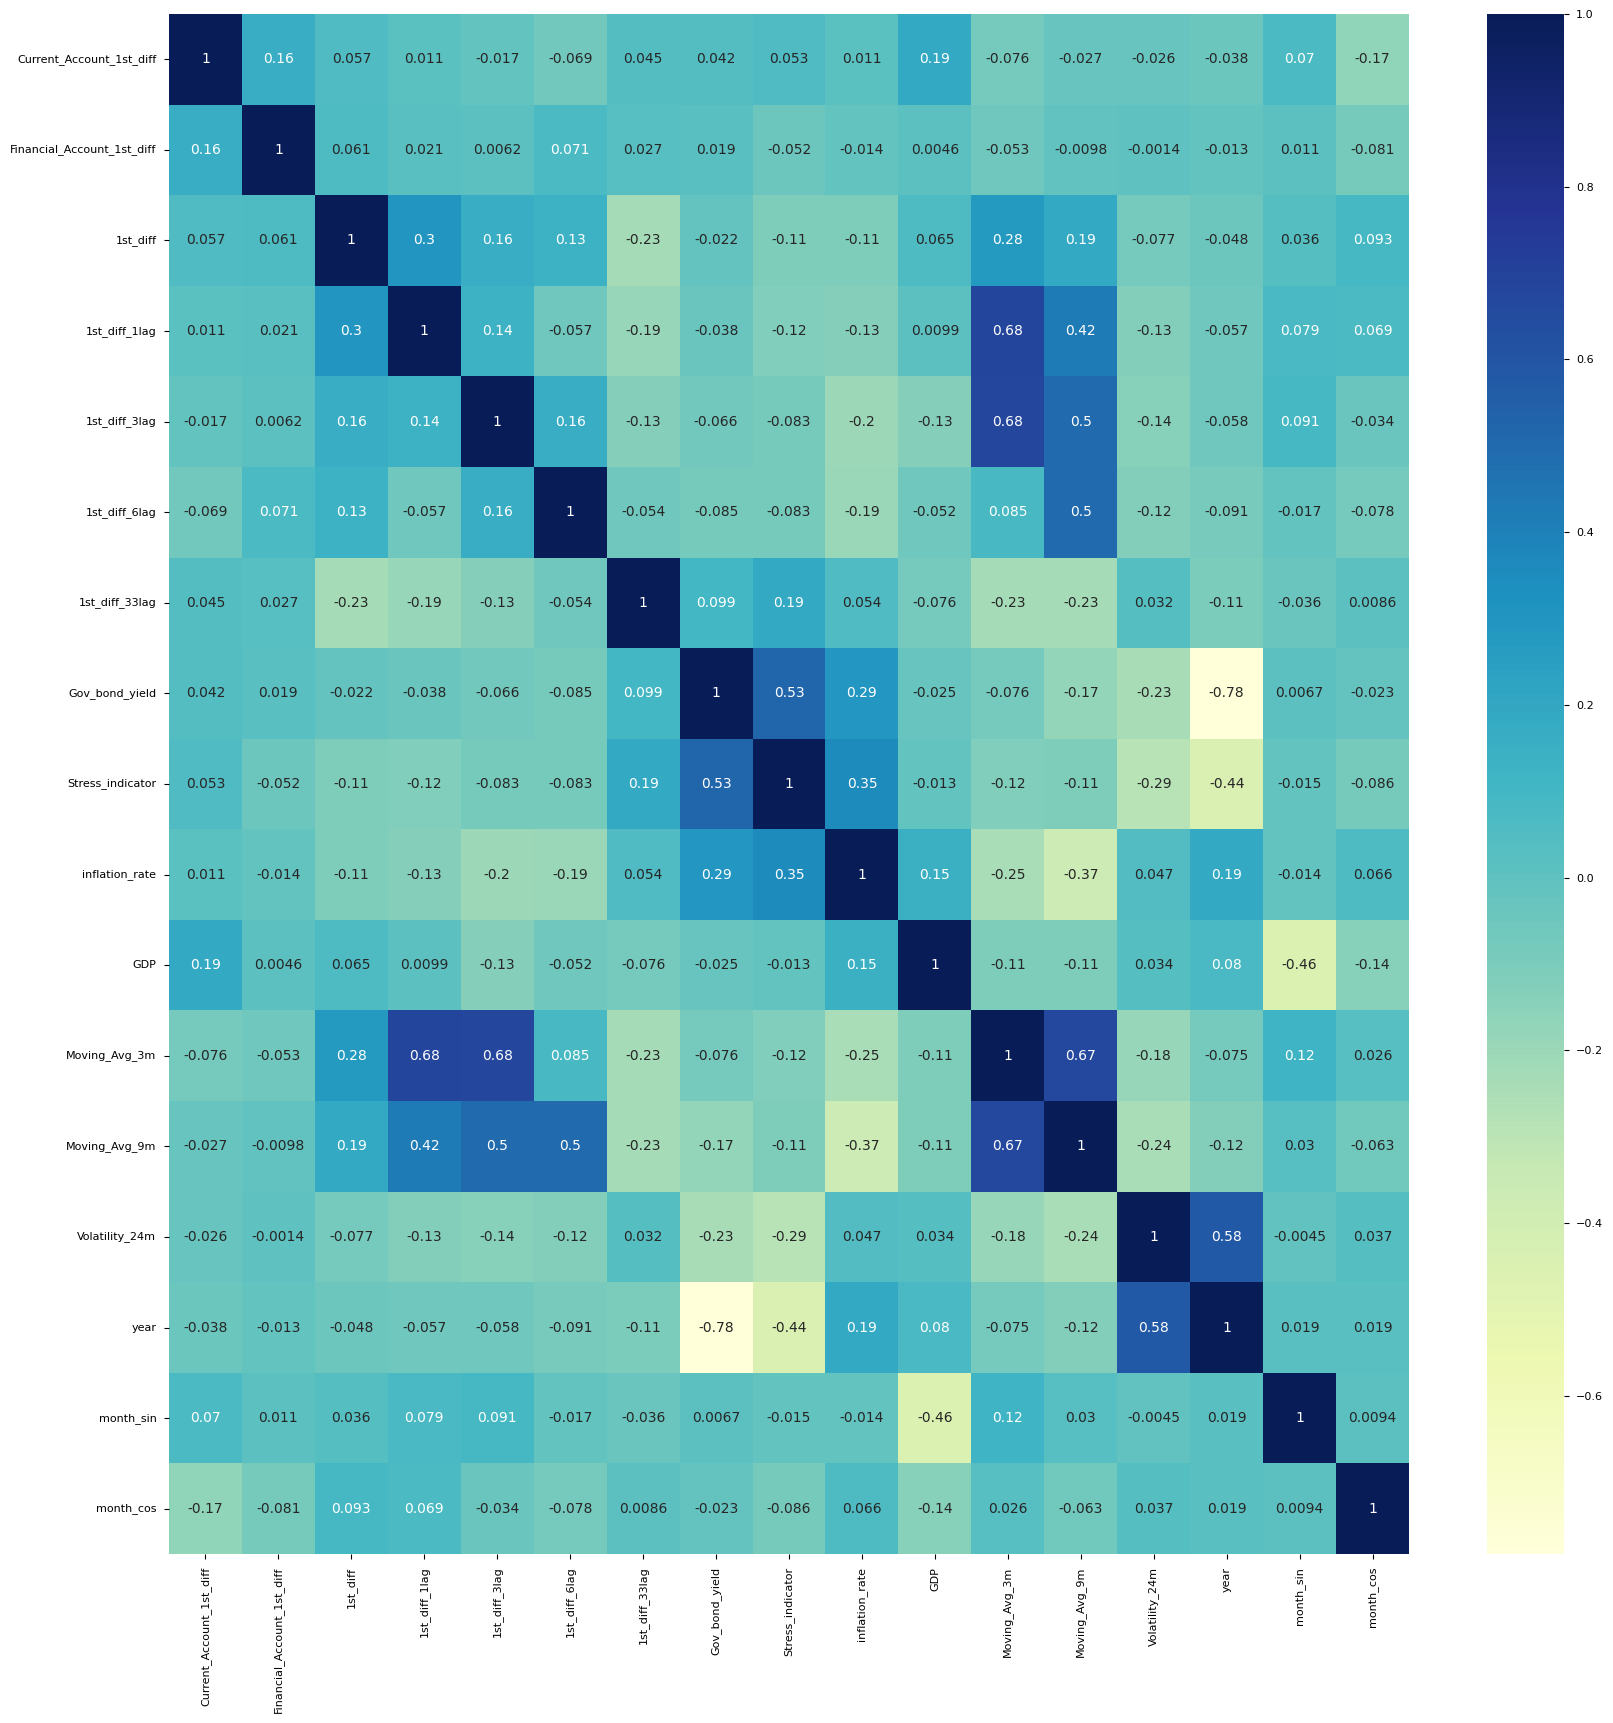

In [ ]:
# check feature correlations
import seaborn as sns
corr_df = feature_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_df,annot=True, cmap="YlGnBu")

In [ ]:
from sklearn.model_selection import train_test_split
# split into train test datasets
X_train, X_test ,y_train, y_test = train_test_split(feature_df.drop(columns='1st_diff'), feature_df["1st_diff"], test_size=0.3, shuffle=False)

In [ ]:
X_train.head()

,Current_Account_1st_diff,Financial_Account_1st_diff,1st_diff_1lag,1st_diff_3lag,1st_diff_6lag,1st_diff_33lag,Gov_bond_yield,Stress_indicator,inflation_rate,GDP,Moving_Avg_3m,Moving_Avg_9m,Volatility_24m,year,month_sin,month_cos
0,0.0,0.0,11119.60,-10857.17,13201.12,1346.89,4.182727,0.1680,3.2,-42783.5,0.000000,0.000000,0.0,2008,0.500000,8.660254e-01
1,2926.0,8026.0,-2681.95,-4088.05,-2193.06,-10287.62,4.144095,0.1315,3.0,-42783.5,-2681.950000,-2681.950000,0.0,2008,0.866025,5.000000e-01
2,-1142.0,-4375.0,-9022.48,11119.60,17258.65,8641.82,4.117632,0.2560,3.6,-42783.5,-5852.215000,-5852.215000,0.0,2008,1.000000,6.123234e-17
3,2784.0,12358.0,17671.24,-2681.95,-10857.17,5084.90,4.310273,0.1582,3.4,23607.6,1988.936667,1988.936667,0.0,2008,0.866025,-5.000000e-01
4,1140.0,-25895.0,4849.86,-9022.48,-4088.05,-945.03,4.422150,0.1051,3.8,23607.6,4499.540000,2704.167500,0.0,2008,0.500000,-8.660254e-01


In [ ]:
X_test.head()

,Current_Account_1st_diff,Financial_Account_1st_diff,1st_diff_1lag,1st_diff_3lag,1st_diff_6lag,1st_diff_33lag,Gov_bond_yield,Stress_indicator,inflation_rate,GDP,Moving_Avg_3m,Moving_Avg_9m,Volatility_24m,year,month_sin,month_cos
127,-1902.0,-2709.0,-253.858074,3408.507273,-13658.667364,-5330.30,1.372391,0.0416,1.6,-4079.3,-12471.450152,-5385.817172,56834.612985,2018,-8.660254e-01,-5.000000e-01
128,-2432.0,897.0,-9741.109545,-40568.999654,4245.125524,-7093.49,1.441800,0.0855,1.5,-4079.3,-16854.655758,-6461.109848,54850.159086,2018,-1.000000e+00,-1.836970e-16
129,2356.0,-9020.0,5132.790000,-253.858074,3046.260476,-9373.56,1.573565,0.1783,1.7,31698.7,-1620.725873,-5897.100702,54232.513921,2018,-8.660254e-01,5.000000e-01
130,-1605.0,14972.0,-3301.016957,-9741.109545,3408.507273,4232.24,1.582409,0.0732,1.6,31698.7,-2636.445501,-5743.440924,52775.697090,2018,-5.000000e-01,8.660254e-01
131,926.0,-11939.0,-326.409862,5132.790000,-40568.999654,-3644.34,1.426211,0.0713,1.2,31698.7,501.787727,-4262.078980,52807.791215,2018,-2.449294e-16,1.000000e+00


## Evaluation helper

In [ ]:
# function to calculate SMPAE
def smape(A, F):
      return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# calculate RMSE, MAPE, SMAPE and R2
def evaluate(actual, predictions):
    #predictions = model.predict(test_features)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mape = mean_absolute_percentage_error(actual, predictions)
    smape_ = smape(actual, predictions)
    r2 = r2_score(actual, predictions)
    print('Model Performance')
    print('TEST RMSE: {:0.2f} '.format(rmse))
    print('TEST MAPE: {:0.2f} '.format(mape))
    print('TEST SMAPE: {:0.2f}% '.format(smape_))
    print('TEST R_squared: {:0.2f} '.format(r2))

## Linear regression

                            OLS Regression Results                            
Dep. Variable:               1st_diff   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1.629
Date:                Tue, 20 Jun 2023   Prob (F-statistic):             0.0727
Time:                        14:57:04   Log-Likelihood:                -1378.8
No. Observations:                 127   AIC:                             2792.
Df Residuals:                     110   BIC:                             2840.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

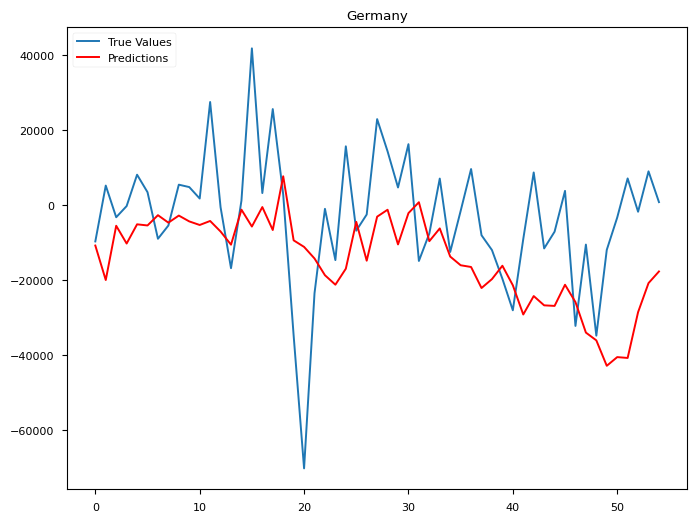

In [ ]:
import statsmodels.api as sm
# linear regression to see the feature importance
simple_lr = sm.OLS(y_train,sm.add_constant(X_train))
results = simple_lr.fit()
print(results.summary())

# linear regression predictions
predictions = simple_lr.predict(results.params,sm.add_constant(X_test))
evaluate(y_test,predictions)
plt.title('Germany')
plt.plot(y_test.reset_index(drop=True),label='True Values')
plt.plot(predictions, color='red', label='Predictions')
plt.legend(loc="upper left")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

N_ESTIMATORS = 50
RANDOM_STATE = 452

#### Normal model

Model Performance
TEST RMSE: 18303.52 
TEST MAPE: 2.60 
TEST SMAPE: 137.86% 
TEST R_squared: -0.12 


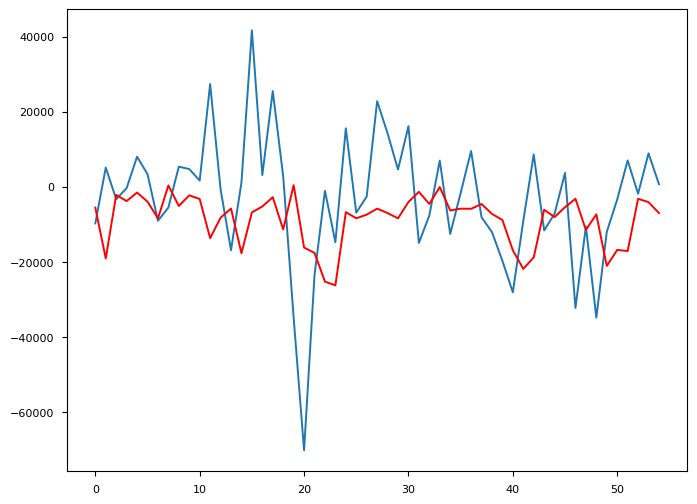

In [ ]:
# untuned random forest
RF_base_model = RandomForestRegressor(n_estimators=N_ESTIMATORS,random_state=RANDOM_STATE)
model_fit = RF_base_model.fit(X_train,y_train)
output = model_fit.predict(X_test)
#run_time = end-start
#print('Model Runtime: {}'.format(run_time.total_seconds()))
evaluate(y_test,output)
observations = y_test.tolist()
plt.plot(y_test.reset_index(drop=True))
plt.plot(output, color='red')
plt.show()

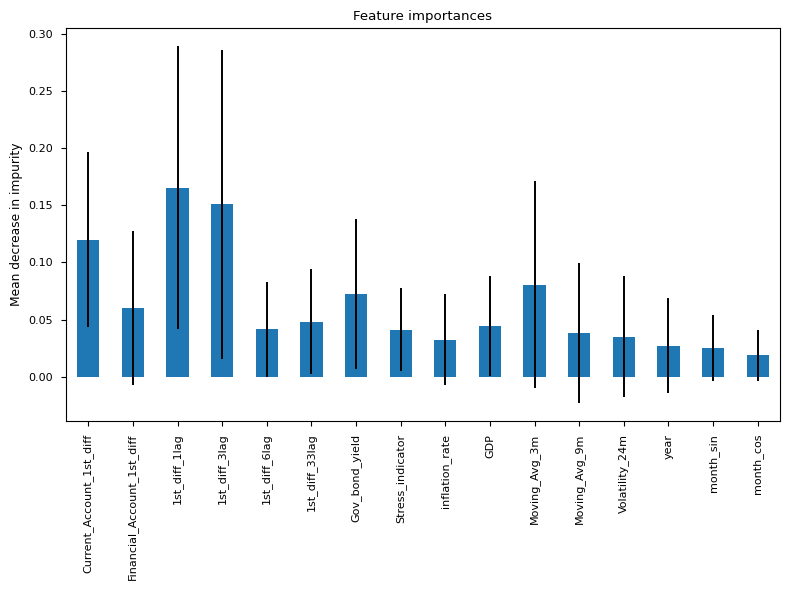

In [ ]:
# untuned random forest feature importance
importances = model_fit.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in model_fit.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Cross Validation - TimeSeriesSplit

In [ ]:

randomForest = RandomForestRegressor()
tscv_anchored = TimeSeriesSplit(n_splits = 5)

In [ ]:
# tunign random forest with randomized search
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gsearch2 = RandomizedSearchCV(estimator=randomForest, n_iter = 500, cv=tscv_anchored, param_distributions=random_grid,verbose=2, random_state=100,n_jobs = -1)
gsearch2.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=500, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 7, 10, 12, 15, 17, 20,
                                                      22, 25, 27, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'min_samples_split': [5, 10, 15, 20],
                                        'n_estimators': [50, 57, 65, 73, 81, 89,
                                                         97, 105, 113, 121, 128,
                                                         136, 144, 152, 160,
                                                         168, 176, 184, 192,
                                                         200]},
                   random_state=100, verbose=2)

In [ ]:
# a function to calculate SMAPE
def smape(A, F):
      return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# calculate RMSE, MAPE, SMAPE and R2
def evaluate_cv(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))
    mape = mean_absolute_percentage_error(test_labels, predictions)
    smape_ = smape(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    print('Model Performance')
    print('TEST RMSE: {:0.2f} '.format(rmse))
    print('TEST MAPE: {:0.2f} '.format(mape))
    print('TEST SMAPE: {:0.2f}% '.format(smape_))
    print('TEST R_squared: {:0.2f} '.format(r2))

    return predictions

In [ ]:
# tuned model results
best_random = gsearch2.best_estimator_
predictions_rf= evaluate_cv(best_random, X_test, y_test)

Model Performance
TEST RMSE: 17020.30 
TEST MAPE: 1.71 
TEST SMAPE: 137.67% 
TEST R_squared: 0.03 


In [ ]:
best_random

RandomForestRegressor(max_depth=22, max_features='sqrt', min_samples_leaf=16,
                      min_samples_split=10, n_estimators=160)

In [ ]:
# save tuned model
import pickle
model_folder = '/content/drive/MyDrive/Thesis/model/Italy/'
filename = 'tuned_rf.sav'
pickle.dump(best_random, open(model_folder + filename, 'wb'))
loaded_model = pickle.load(open(model_folder+filename, 'rb'))
result = loaded_model.predict(X_test)
evaluate(result,y_test)

Model Performance
TEST RMSE: 17020.30 
TEST MAPE: 3.43 
TEST SMAPE: 137.67% 
TEST R_squared: -37.31 


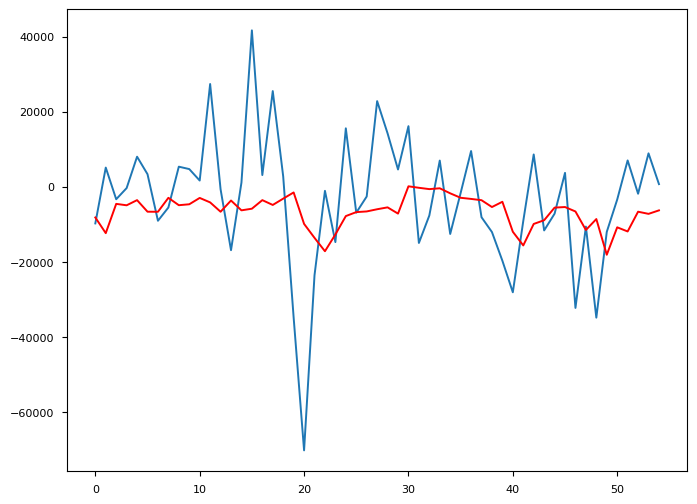

In [ ]:
# plot observations and predictions
plt.plot(y_test.reset_index(drop=True))
plt.plot(predictions_anchored, color='red')
plt.show()

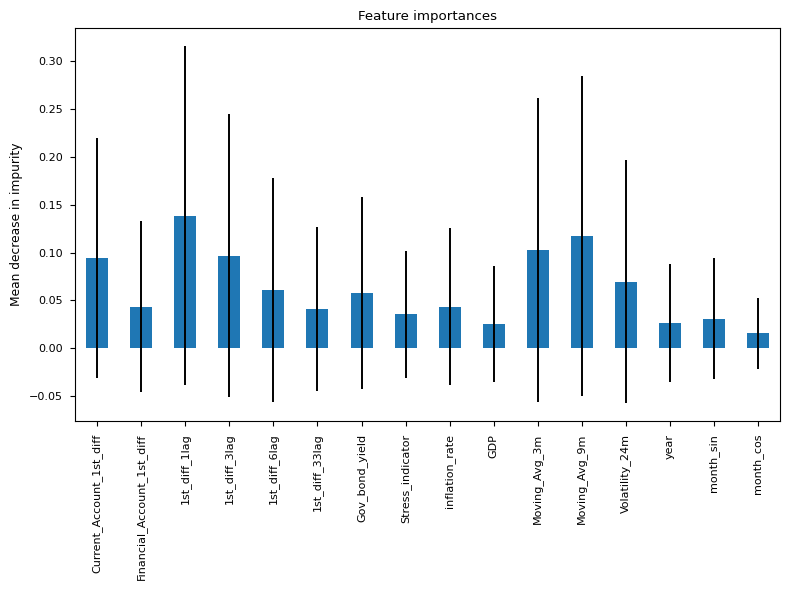

In [ ]:
# feature importance analysis
importances = best_random.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in best_random.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## XGBoost

Model Performance
TEST RMSE: 20459.79 
TEST MAPE: 3.08 
TEST SMAPE: 154.96% 
TEST R_squared: -0.40 


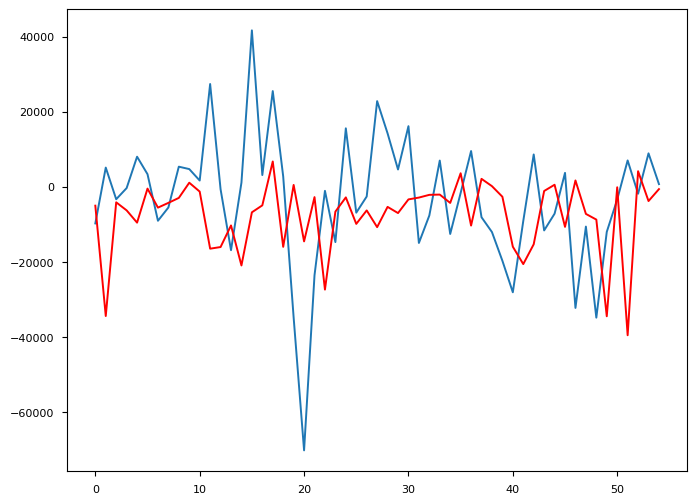

In [ ]:
# untuned xgboost
from xgboost import XGBRegressor

xgboost = XGBRegressor(objective='reg:squarederror')

xgb_model = xgboost.fit(X_train,y_train)
output = xgb_model.predict(X_test)

evaluate(y_test,output)

plt.plot(y_test.reset_index(drop=True))
plt.plot(output, color='red')
plt.show()


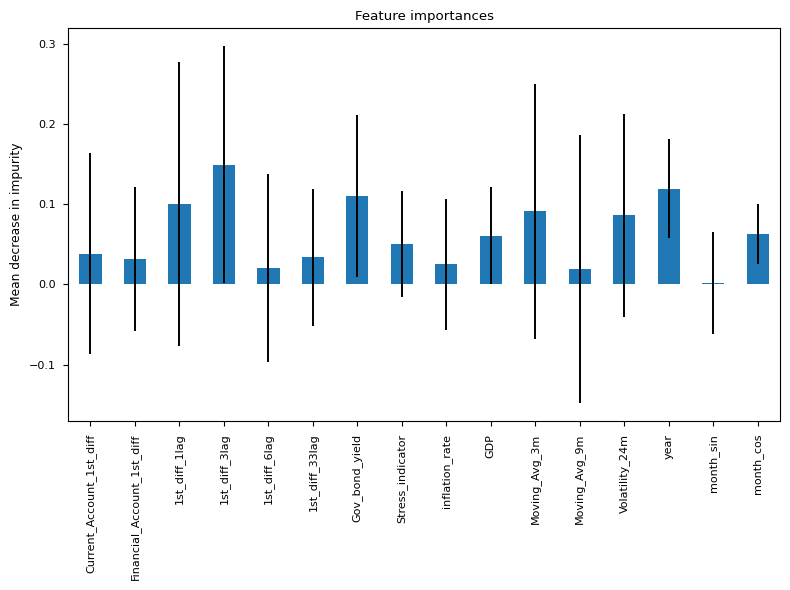

In [ ]:
# untuned xgboost feature importance
importances = xgb_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
#std = np.std([tree.feature_importances_ for tree in xgb_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Cross Validation

In [ ]:
# tuning xgboost with randomized search
tscv_anchored = TimeSeriesSplit(n_splits = 5)
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gsearch3 = RandomizedSearchCV(estimator=xgboost, n_iter = 500, cv=tscv_anchored, param_distributions=random_grid,verbose=2, random_state=42, n_jobs = -1)
gsearch3.fit(X_train, y_train)

In [ ]:
# tuned model result
best_xgb = gsearch3.best_estimator_
output = evaluate_cv(best_xgb, X_test, y_test)

Model Performance
TEST RMSE: 21326.05 
TEST MAPE: 2.74 
TEST SMAPE: 156.04% 
TEST R_squared: -0.52 


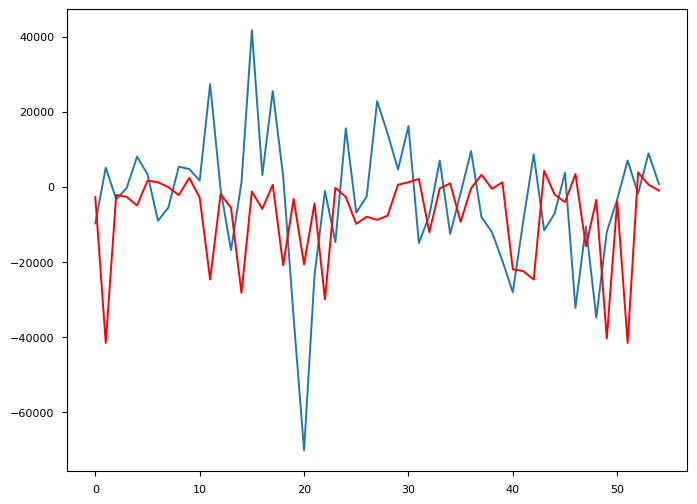

In [ ]:
# plot observations and tuned model predictions
plt.plot(y_test.reset_index(drop=True))
plt.plot(output, color='red')
plt.show()

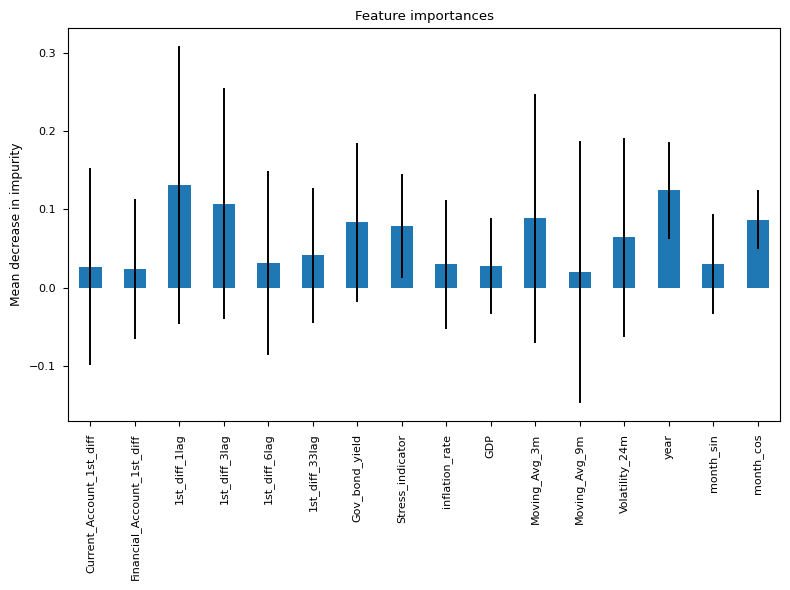

In [ ]:
#tuned model feature importance
importances = best_xgb.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
#std = np.std([tree.feature_importances_ for tree in model_fit.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## LGBM

In [ ]:
# params = {
#     'objective': 'regression',
#     'device': 'cpu',
#     'boosting': 'goss',#method of boosting (gbdt, rf, dart, goss) --> dart<gbdt<goss ( provides a new sampling method for GBDT by separating those instances with larger gradients)
#     'num_iterations': 600,
#     'lambda_l1':15, #L1 regularization ---> reduces both overfitting and test error
#     'lambda_l2': 2, # L2 regularization
#     'max_depth':-1, #limit the max depth for tree model
#     'max_bin':500, # Small number of bins may reduce training accuracy but can deal with over-fitting
#     'num_leaves': 200, #max number of leaves in one tree
#     'colsample_bytree': 1, #% features used while const tree
#     'subsample': 0.8, # subsample ratio of the training instance
#     'learning_rate': 0.04,
#     'metric': 'rmse',
#     'verbose': -1 #debugging

# }

Model Performance
TEST RMSE: 17785.18 
TEST MAPE: 2.14 
TEST SMAPE: 142.48% 
TEST R_squared: -0.06 


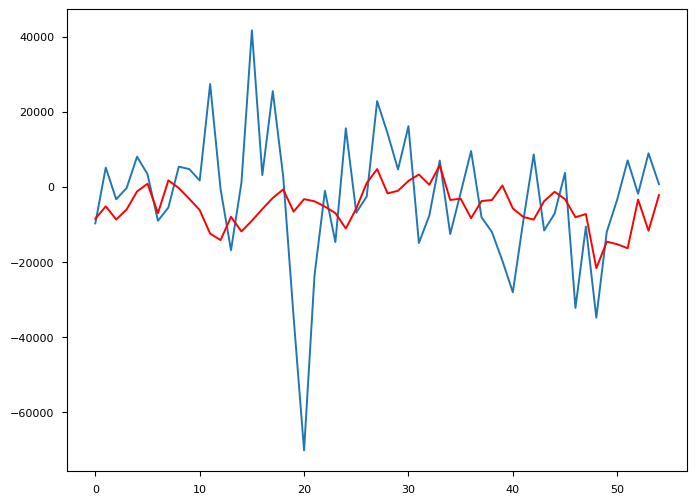

In [ ]:
# untuned lgbm
import lightgbm
from lightgbm import LGBMRegressor
import datetime
from sklearn.metrics import mean_squared_error

model_lgb = LGBMRegressor()
#model_lgb.set_params(**params)
model_fit = model_lgb.fit(X_train,y_train,eval_metric ='rmse')
output = model_fit.predict(X_test)
evaluate(y_test,output)

#run_time = end-start
#print('Model Runtime: {}'.format(run_time.total_seconds()))

observations = y_test.tolist()
plt.plot(y_test.reset_index(drop=True))
plt.plot(output, color='red')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

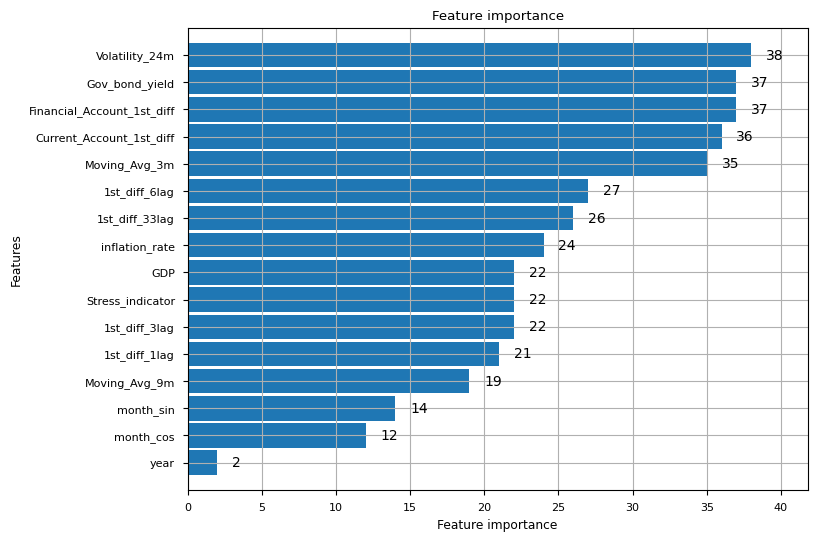

In [ ]:
# untuned lgbm feature importance results
lightgbm.plot_importance(model_fit, max_num_features = 60, height=.9)

### Model tuning

In [ ]:
# tuning lgbm with randomized search
param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1],
              'n_estimators' : [int(x) for x in np.linspace(10,300, num = 30)],
              'num_leaves': [int(x) for x in np.linspace(10, 100, num = 10)],
              'min_child_samples': [int(x) for x in np.linspace(10, 50, num = 10)] ,
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              #'subsample': [int(x) for x in np.linspace(1, 10, num = 5)],
              'max_depth': [-1, 1, 2, 3, 5, 8, 10, 15, 20],
              #'colsample_bytree': sp_uniform(loc = 0.4, scale = 0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
              }

# Number of combinations
n_iter = 500
tscv_anchored = TimeSeriesSplit(n_splits = 5)
# Intializing lgbm and lunching the search
lgbm_clf = LGBMRegressor(random_state = 42, n_jobs = -1)
grid_search = RandomizedSearchCV(
    estimator = lgbm_clf, param_distributions = param_test,
    n_iter = n_iter,
    scoring = 'neg_mean_squared_error',
    cv = tscv_anchored,
    refit = True,
    random_state = 42,
    verbose = True)

grid_search.fit(X_train, y_train, )#**fit_params
opt_parameters = grid_search.best_params_


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [ ]:
def smape(A, F):
      return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# calculate RMSE, MAPE, SMAPE and R2
def evaluate_cv(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))
    mape = mean_absolute_percentage_error(test_labels, predictions)
    smape_ = smape(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    print('Model Performance')
    print('TEST RMSE: {:0.2f} '.format(rmse))
    print('TEST MAPE: {:0.2f} '.format(mape))
    print('TEST SMAPE: {:0.2f}% '.format(smape_))
    print('TEST R_squared: {:0.2f} '.format(r2))

    return predictions

In [ ]:
# best lgbm result
best_lgbm = grid_search.best_estimator_
predictions_anchored = evaluate_cv(best_lgbm, X_test, y_test)

Model Performance
TEST RMSE: 16902.71 
TEST MAPE: 1.73 
TEST SMAPE: 136.30% 
TEST R_squared: 0.04 


In [ ]:
best_lgbm

LGBMRegressor(learning_rate=0.03, max_depth=2, min_child_samples=27,
              min_child_weight=10.0, n_estimators=50, num_leaves=90,
              random_state=42, reg_alpha=0, reg_lambda=0)

In [ ]:
# save tuned lgbm
import pickle
model_folder = '/content/drive/MyDrive/Thesis/model/Italy/'
filename = 'tuned_lgbm_.sav'
pickle.dump(best_lgbm, open(model_folder + filename, 'wb'))

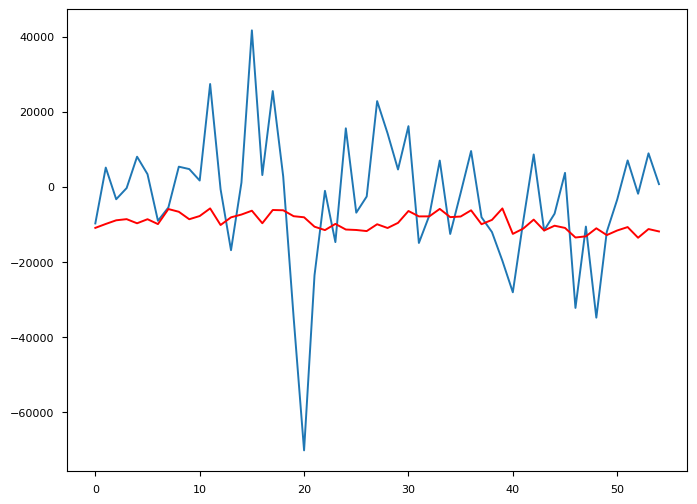

In [ ]:
# tuned model predictions
plt.plot(y_test.reset_index(drop=True))
plt.plot(predictions_anchored, color='red')
plt.show()

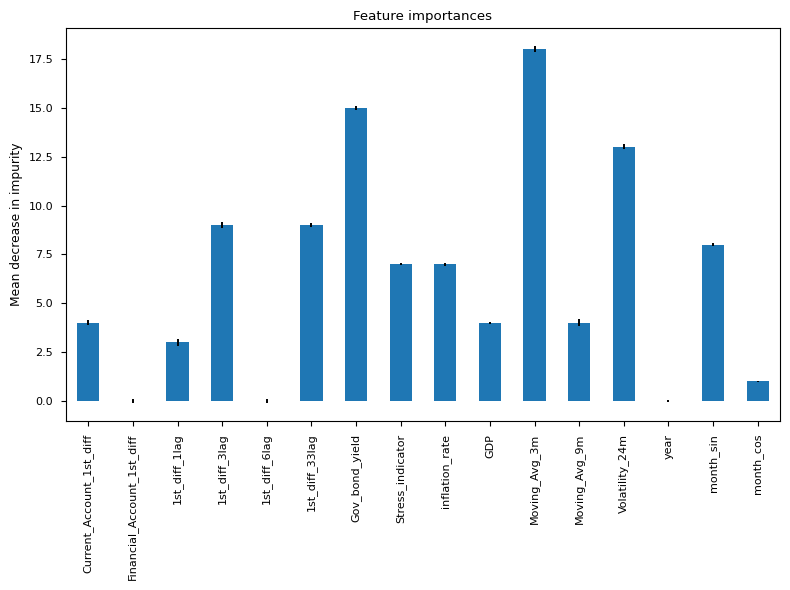

In [ ]:
# tuned model feature importance
importances = best_lgbm.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
#std = np.std([tree.feature_importances_ for tree in best_random.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## CatBoost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.2 MB/s eta 0:00:00


In [ ]:
import catboost as cb

In [ ]:
# catboost train and test data
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

In [ ]:
# tuned catboost
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

流式输出内容被截断，只能显示最后 5000 行内容。
156:	learn: 5030.9872957	test: 11587.2046227	best: 11537.3278189 (144)	total: 422ms	remaining: 115ms
157:	learn: 4989.5010867	test: 11574.0318133	best: 11537.3278189 (144)	total: 423ms	remaining: 112ms
158:	learn: 4961.4726055	test: 11558.9738380	best: 11537.3278189 (144)	total: 424ms	remaining: 109ms
159:	learn: 4932.0996242	test: 11554.0580031	best: 11537.3278189 (144)	total: 430ms	remaining: 108ms
160:	learn: 4900.5717532	test: 11543.8768436	best: 11537.3278189 (144)	total: 431ms	remaining: 105ms
161:	learn: 4864.7180469	test: 11563.9429343	best: 11537.3278189 (144)	total: 433ms	remaining: 101ms
162:	learn: 4826.1370081	test: 11551.1304782	best: 11537.3278189 (144)	total: 434ms	remaining: 98.5ms
163:	learn: 4790.0518502	test: 11568.0823783	best: 11537.3278189 (144)	total: 435ms	remaining: 95.5ms
164:	learn: 4772.8005141	test: 11579.4651644	best: 11537.3278189 (144)	total: 442ms	remaining: 93.7ms
165:	learn: 4742.6757168	test: 11589.0808183	best: 11537.3278

{'params': {'depth': 4,
  'iterations': 200,
  'learning_rate': 0.03,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               

In [ ]:
# tuned catboost result
pred = model.predict(X_test)
evaluate(y_test, pred)

Model Performance
TEST RMSE: 17510.12 
TEST MAPE: 2.36 
TEST SMAPE: 139.86% 
TEST R_squared: -0.03 


In [ ]:
# save catboost model
import pickle
model_folder = '/content/drive/MyDrive/Thesis/model/'
filename = 'tuned_cb_lux.sav'
pickle.dump(model, open(model_folder + filename, 'wb'))

## SVM

In [ ]:
# untuned SVM
from sklearn import svm
regr = svm.SVR(kernel='sigmoid')
svm_model = regr.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
evaluate(svm_pred,y_test)

Model Performance
TEST RMSE: 17292.20 
TEST MAPE: 4.56 
TEST SMAPE: 150.91% 
TEST R_squared: -127528345.63 


In [ ]:
# adjusted r2 score
r2_score(y_test.values, svm_pred)

-0.0009525302616086861

In [ ]:
# adjusted MAPE
mean_absolute_percentage_error(y_test.values, svm_pred)

1.2990204507670629

In [ ]:
# tuning SVM with grid search
tscv_anchored = TimeSeriesSplit(n_splits = 5)
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(regr, param_grid,refit=True,verbose=-1,n_jobs=-1,cv = tscv_anchored)
grid.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(kernel='sigmoid'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=-1)

In [ ]:
# tuned model result
best_svm = grid.best_estimator_
predictions_anchored = evaluate_cv(best_svm, X_test, y_test)

Model Performance
TEST RMSE: 17292.61 
TEST MAPE: 1.30 
TEST SMAPE: 150.90% 
TEST R_squared: -0.00 


In [ ]:
# save tuned model
import pickle
model_folder = '/content/drive/MyDrive/Thesis/model/Italy/'
filename = 'tuned_SVM.sav'
pickle.dump(model, open(model_folder + filename, 'wb'))

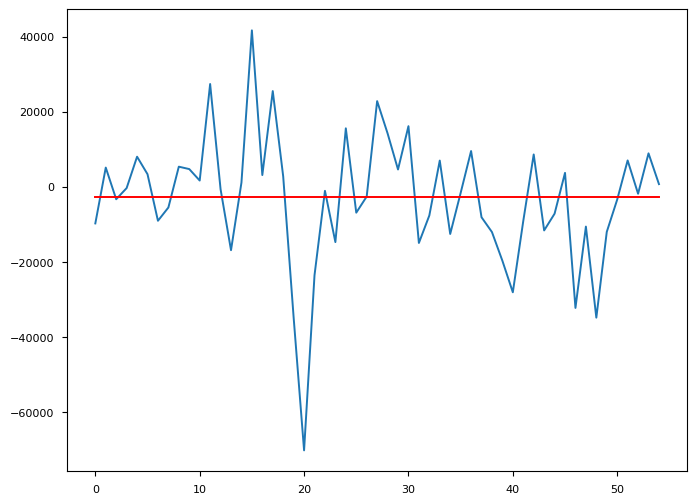

In [ ]:
# plot predictions and observations
plt.plot(y_test.reset_index(drop=True))
plt.plot(predictions_anchored, color='red')
plt.show()

## Stacked model

In [ ]:
import pandas as pd
import pickle
model_folder = '/content/drive/MyDrive/Thesis/model/Italy/'

In [ ]:
# load saved models
stacked_df = pd.DataFrame()
loaded_rf = pickle.load(open(model_folder+'tuned_rf.sav', 'rb'))
loaded_lgbm = pickle.load(open(model_folder+'tuned_lgbm.sav', 'rb'))
loaded_cb = pickle.load(open(model_folder+'tuned_SVM.sav', 'rb'))
# saved models predict on train set
stacked_df['random_forest'] = loaded_rf.predict(X_train)
stacked_df['LGBM'] = loaded_lgbm.predict(X_train)
stacked_df['SVM'] = loaded_cb.predict(X_train)
# saved models predict on test set
stacked_pred_df = pd.DataFrame()
stacked_pred_df['random_forest'] = loaded_rf.predict(X_test)
stacked_pred_df['LGBM'] = loaded_lgbm.predict(X_test)
stacked_pred_df['SVM'] = loaded_cb.predict(X_test)

In [ ]:
stacked_df.head()

,random_forest,LGBM,SVM
0,-296.970073,-546.872736,-2681.950000
1,-2404.814611,-1179.613217,-2683.143676
2,-2031.137052,-1471.093887,-2682.608154
3,-267.997680,-257.155634,-2676.045264
4,-473.617711,-841.117046,-2676.725294


In [ ]:
stacked_pred_df.head()

,random_forest,LGBM,SVM
0,-7913.481879,-9225.921717,-2680.753496
1,-8763.105173,-9476.723789,-2682.354464
2,-4947.804487,-6771.315270,-2678.035098
3,-5993.416402,-6613.309222,-2678.680722
4,-3285.898210,-2197.115764,-2679.045931


In [ ]:
# stack models with linear regressions
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
stacked_model = linear.fit(stacked_df[['random_forest','LGBM','SVM']],y_train)
stack_predictions = stacked_model.predict(stacked_pred_df[['random_forest','LGBM','SVM']])
evaluate(stack_predictions,y_test.values)

Model Performance
TEST RMSE: 17555.27 
TEST MAPE: 34.71 
TEST SMAPE: 139.49% 
TEST R_squared: -6.14 


In [ ]:
# adjusted r2
r2_score(y_test.values, stack_predictions)

-0.03163961835972384

In [ ]:
# adjusted MAPE
mean_absolute_percentage_error(y_test.values, stack_predictions)

2.4099629839570555

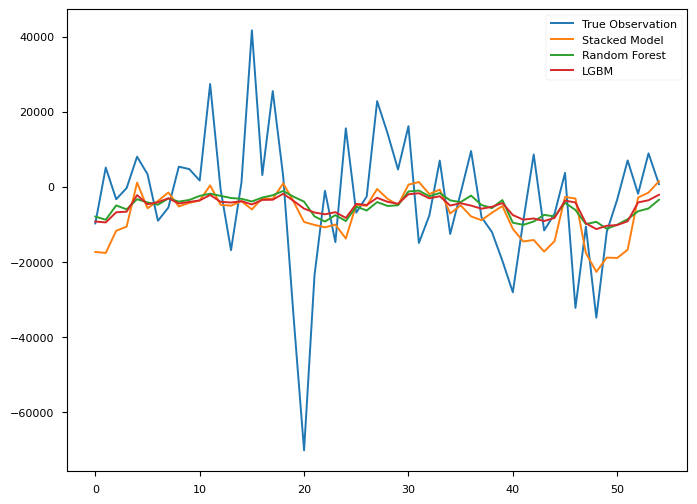

In [ ]:
# model results plot
plt.plot(y_test.reset_index(drop=True),label='True Observation')
plt.plot(stack_predictions,label='Stacked Model')
plt.plot(stacked_pred_df['random_forest'],label='Random Forest')
plt.plot(stacked_pred_df['LGBM'],label='LGBM')
plt.plot(stacked_pred_df['SVM'],label='SVM')
plt.legend()
plt.show()